TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# ============================================
# FUNCIONES
# ============================================

def calculate_iou(box1, box2):
    """Calcula IoU entre dos bounding boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0
    
    return inter_area / union_area


def extract_features(contour):
    """Extrae características geométricas básicas"""
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    
    aspect_ratio = float(w) / h if h != 0 else 0
    compactness = (perimeter ** 2) / area if area > 0 else 0
    bbox_area = w * h
    extent = area / bbox_area if bbox_area > 0 else 0
    
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    
    return {
        'area': area,
        'perimeter': perimeter,
        'aspect_ratio': aspect_ratio,
        'compactness': compactness,
        'extent': extent,
        'solidity': solidity,
        'width': w,
        'height': h
    }


def classify_particle(features):
    """Clasifica partícula basado en características geométricas"""
    ar = features['aspect_ratio']
    compactness = features['compactness']
    extent = features['extent']
    solidity = features['solidity']
    
    if solidity < 0.85 and compactness > 15:
        return 'FRA'
    
    if 0.7 <= ar <= 1.3 and extent > 0.7 and solidity > 0.85:
        return 'PEL'
    
    if solidity < 0.75:
        return 'TAR'
    
    if ar > 1.5 or ar < 0.6:
        return 'FRA'
    
    return 'PEL'


def process_pipeline(img, gray, use_clahe=False, clip_limit=3.0):
    """
    Pipeline completo de procesamiento
    Retorna: edges, contours, filtered_contours, blurred (o enhanced si CLAHE)
    """
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
        processed = clahe.apply(gray)
    else:
        processed = gray.copy()
    
    blurred = cv2.GaussianBlur(processed, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filtrar por área
    min_area = 30
    max_area = 5000
    filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
    
    return edges, contours, filtered_contours, processed


def match_and_classify(filtered_contours, annotations):
    """Empareja contornos con anotaciones y clasifica"""
    y_true = []
    y_pred = []
    matched_data = []
    
    for ann in annotations:
        ann_box = (ann['x'], ann['y'], ann['width'], ann['height'])
        
        best_iou = 0
        best_contour = None
        
        for contour in filtered_contours:
            x, y, w, h = cv2.boundingRect(contour)
            contour_box = (x, y, w, h)
            iou = calculate_iou(ann_box, contour_box)
            
            if iou > best_iou:
                best_iou = iou
                best_contour = contour
        
        if best_iou > 0.2:
            features = extract_features(best_contour)
            predicted_class = classify_particle(features)
            
            y_true.append(ann['class'])
            y_pred.append(predicted_class)
            
            x, y, w, h = cv2.boundingRect(best_contour)
            matched_data.append({
                'contour': best_contour,
                'true_class': ann['class'],
                'pred_class': predicted_class,
                'bbox': (x, y, w, h),
                'iou': best_iou,
                'features': features
            })
            
            ann['matched'] = True
    
    return y_true, y_pred, matched_data


def compute_confusion_matrix(y_true, y_pred):
    """Calcula matriz de confusión y métricas"""
    classes = sorted(list(set(y_true)))
    n_classes = len(classes)
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        true_idx = class_to_idx[true]
        pred_idx = class_to_idx[pred]
        cm[true_idx, pred_idx] += 1
    
    return cm, classes


In [ ]:
# Cargar imagen y anotaciones
img = cv2.imread('MPs_test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(f"Dimensiones de imagen: {img.shape}")

# Cargar anotaciones
annotations = []
with open('MPs_test_bbs.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    
    for row in reader:
        annotations.append({
            'x': float(row[1]),
            'y': float(row[2]),
            'width': float(row[3]) - float(row[1]),
            'height': float(row[4]) - float(row[2]),
            'class': row[0],
            'matched': False
        })

print(f"Anotaciones cargadas: {len(annotations)}")


Dimensiones de imagen: (1186, 790, 3)
Anotaciones cargadas: 97


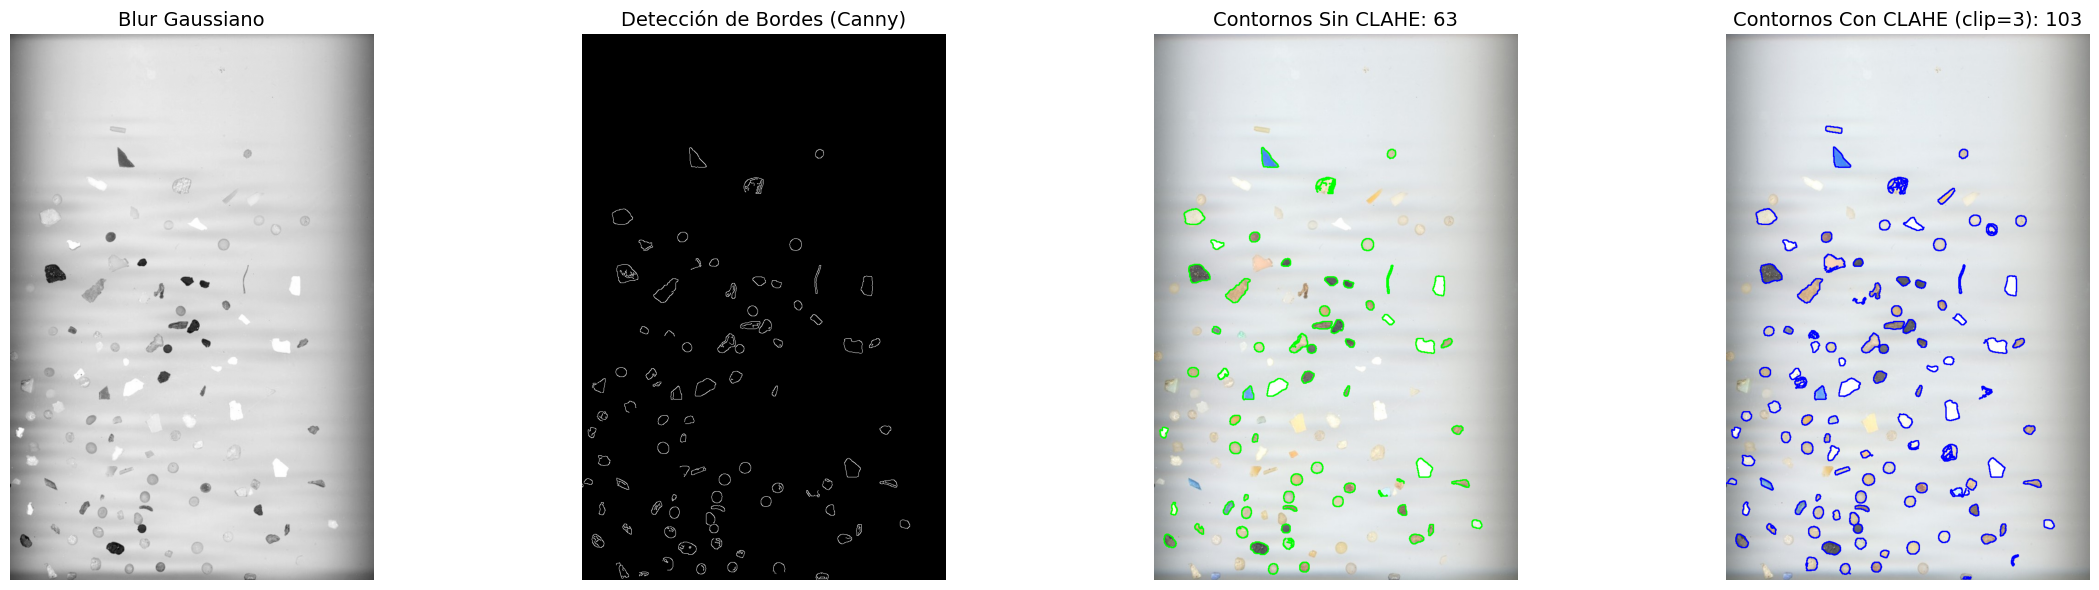

✓ Pasos de procesamiento visualizados
  - Contornos sin CLAHE: 63
  - Contornos con CLAHE: 103
  - Diferencia: +40 contornos


In [ ]:
# Procesar SIN CLAHE (para visualización)
edges_base, _, filtered_contours_base, blurred = process_pipeline(img, gray, use_clahe=False)

# Procesar CON CLAHE (para visualización)
edges_clahe, _, filtered_contours_clahe, enhanced = process_pipeline(img, gray, use_clahe=True, clip_limit=3.0)

# Visualizar pasos de procesamiento
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(blurred, cmap='gray')
axes[0].set_title('Blur Gaussiano', fontsize=14)
axes[0].axis('off')

axes[1].imshow(edges_base, cmap='gray')
axes[1].set_title('Detección de Bordes (Canny)', fontsize=14)
axes[1].axis('off')

# Imagen con contornos detectados SIN CLAHE
img_contours_base = img.copy()
cv2.drawContours(img_contours_base, filtered_contours_base, -1, (0, 255, 0), 2)
axes[2].imshow(cv2.cvtColor(img_contours_base, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Contornos Sin CLAHE: {len(filtered_contours_base)}', fontsize=14)
axes[2].axis('off')

# Imagen con contornos detectados CON CLAHE
img_contours_clahe = img.copy()
cv2.drawContours(img_contours_clahe, filtered_contours_clahe, -1, (255, 0, 0), 2)
axes[3].imshow(cv2.cvtColor(img_contours_clahe, cv2.COLOR_BGR2RGB))
axes[3].set_title(f'Contornos Con CLAHE (clip=3): {len(filtered_contours_clahe)}', fontsize=14)
axes[3].axis('off')

plt.tight_layout()
plt.savefig('microplastics_results/pasos_procesamiento.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Configuraciones a comparar
configs = [
    {'name': 'Solo Canny', 'use_clahe': False, 'clip_limit': None},
    {'name': 'Canny + CLAHE (clip=3)', 'use_clahe': True, 'clip_limit': 3.0},
    {'name': 'Canny + CLAHE (clip=5)', 'use_clahe': True, 'clip_limit': 5.0}
]

results = []

for config in configs:
    # Resetear matched en anotaciones
    for ann in annotations:
        ann['matched'] = False
    
    # Procesar
    edges, contours, filtered_contours, processed = process_pipeline(
        img, gray, 
        use_clahe=config['use_clahe'], 
        clip_limit=config['clip_limit'] if config['clip_limit'] else 3.0
    )
    
    # Emparejar y clasificar
    y_true, y_pred, matched_data = match_and_classify(filtered_contours, annotations)
    
    # Calcular métricas
    if len(y_true) > 0:
        cm, classes = compute_confusion_matrix(y_true, y_pred)
        accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0
        recall = len(matched_data) / len(annotations) * 100
    else:
        cm = None
        classes = []
        accuracy = 0
        recall = 0
    
    results.append({
        'config': config,
        'confusion_matrix': cm,
        'classes': classes,
        'accuracy': accuracy,
        'recall': recall,
        'matched_data': matched_data,
        'y_true': y_true,
        'y_pred': y_pred,
        'filtered_contours': filtered_contours
    })
    
    print(f"\n{config['name']}:")
    print(f"  - Contornos filtrados: {len(filtered_contours)}")
    print(f"  - Partículas emparejadas: {len(matched_data)}/{len(annotations)}")
    print(f"  - Recall: {recall:.2f}%")
    print(f"  - Accuracy: {accuracy:.3f}")


Solo Canny:
  - Contornos filtrados: 63
  - Partículas emparejadas: 55/97
  - Recall: 56.70%
  - Accuracy: 0.491

Canny + CLAHE (clip=3):
  - Contornos filtrados: 103
  - Partículas emparejadas: 85/97
  - Recall: 87.63%
  - Accuracy: 0.506

Canny + CLAHE (clip=5):
  - Contornos filtrados: 101
  - Partículas emparejadas: 83/97
  - Recall: 85.57%
  - Accuracy: 0.566


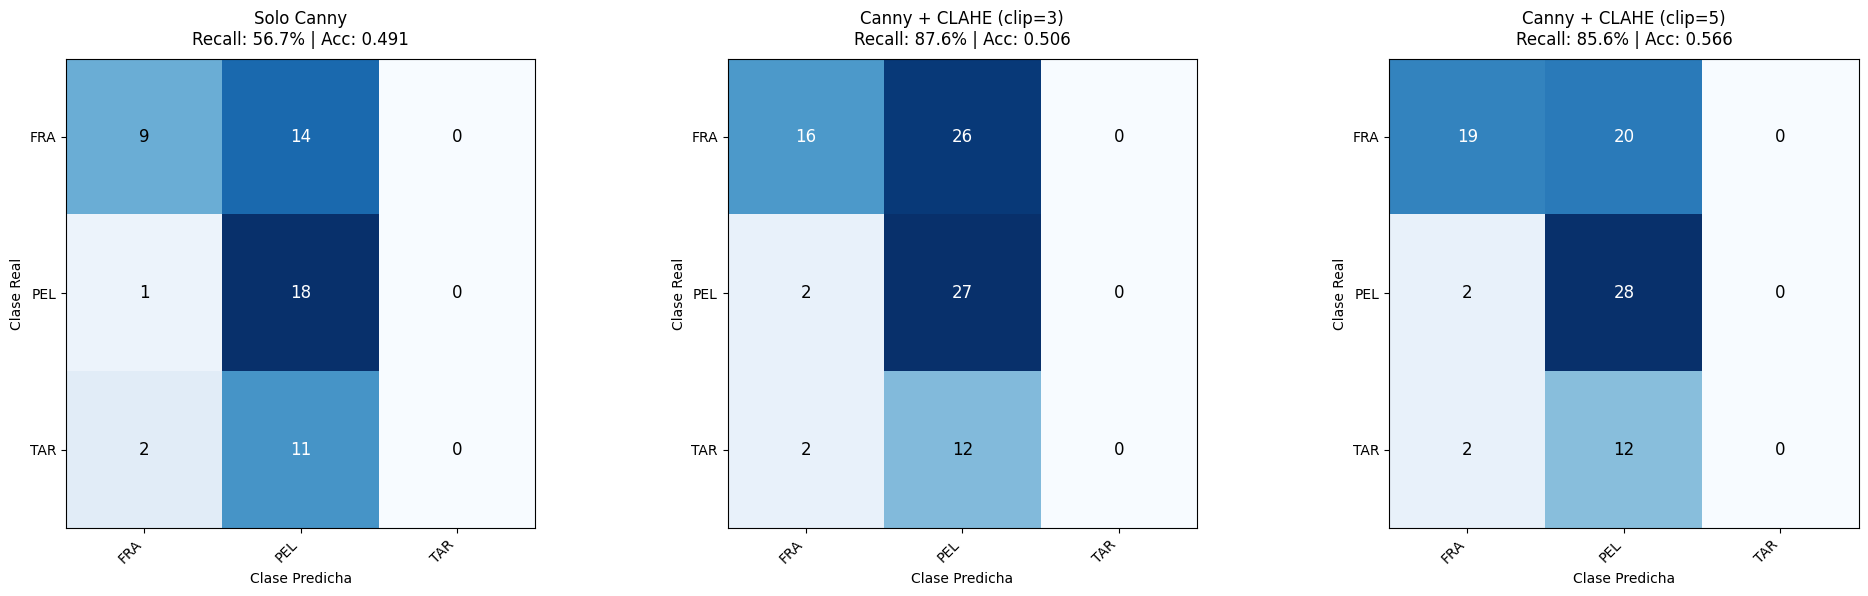

In [12]:
# Crear figura con 3 matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, result in enumerate(results):
    ax = axes[idx]
    cm = result['confusion_matrix']
    classes = result['classes']
    config_name = result['config']['name']
    
    if cm is not None and len(classes) > 0:
        # Mostrar matriz
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f"{config_name}\nRecall: {result['recall']:.1f}% | Acc: {result['accuracy']:.3f}", 
                     fontsize=12, pad=10)
        
        # Etiquetas
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes)
        
        # Añadir valores
        thresh = cm.max() / 2.
        for i in range(len(classes)):
            for j in range(len(classes)):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontsize=12)
        
        ax.set_ylabel('Clase Real', fontsize=10)
        ax.set_xlabel('Clase Predicha', fontsize=10)
    else:
        ax.text(0.5, 0.5, 'Sin datos', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(config_name)
        ax.axis('off')

plt.tight_layout()
plt.savefig('microplastics_results/comparacion_matrices_confusion.png', dpi=300, bbox_inches='tight')
plt.show()


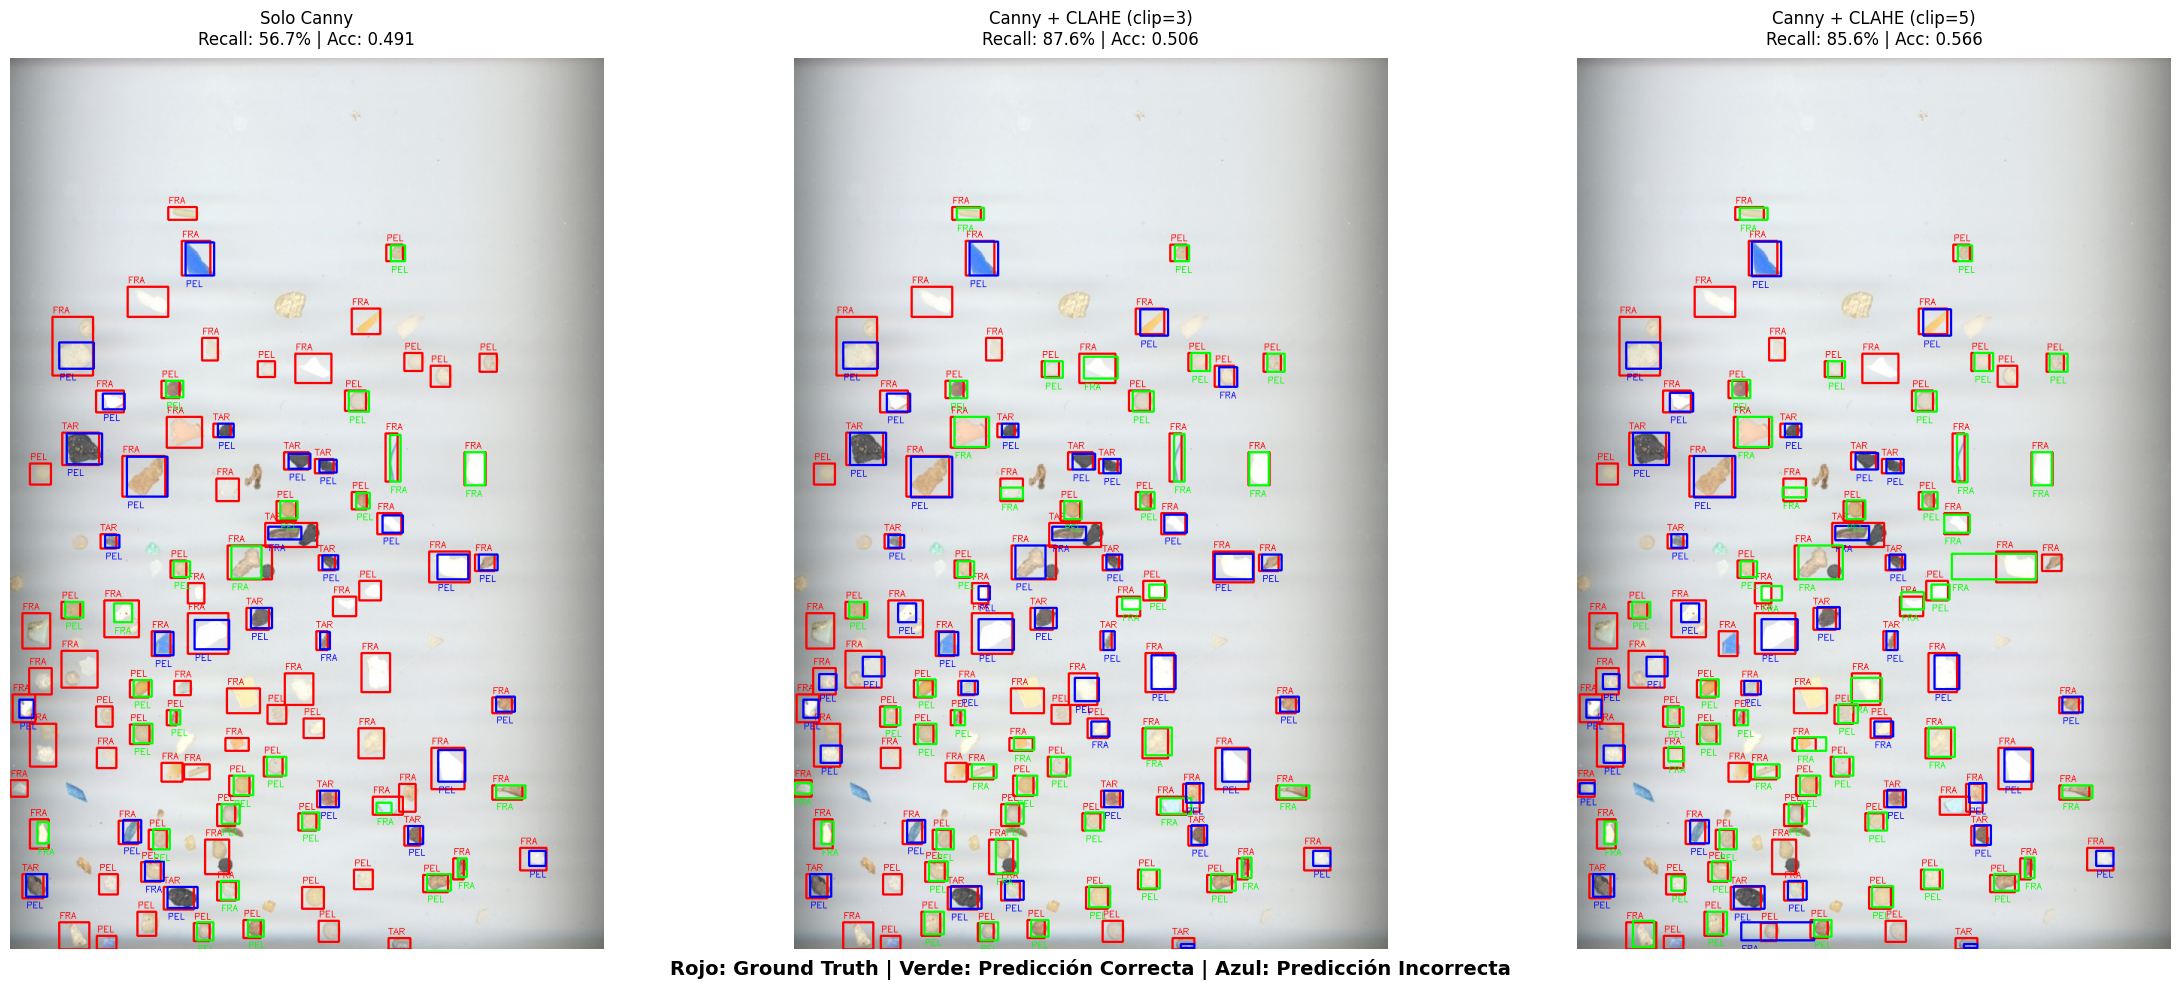

In [13]:
# Crear figura con 3 imágenes lado a lado
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

for idx, result in enumerate(results):
    ax = axes[idx]
    matched_data = result['matched_data']
    
    # Crear copia de la imagen
    img_result = img.copy()
    
    # Ground truth en rojo
    for ann in annotations:
        x = int(ann['x'])
        y = int(ann['y'])
        w = int(ann['width'])
        h = int(ann['height'])
        cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(img_result, ann['class'], (x, y - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    # Predicciones: verde=correcto, azul=incorrecto
    for data in matched_data:
        x, y, w, h = data['bbox']
        color = (0, 255, 0) if data['true_class'] == data['pred_class'] else (255, 0, 0)
        
        cv2.rectangle(img_result, (x, y), (x + w, y + h), color, 2)
        label = f"{data['pred_class']}"
        cv2.putText(img_result, label, (x, y + h + 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    # Mostrar imagen
    ax.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{result['config']['name']}\nRecall: {result['recall']:.1f}% | Acc: {result['accuracy']:.3f}", 
                fontsize=12, pad=10)
    ax.axis('off')

# Leyenda común
fig.text(0.5, 0.02, 'Rojo: Ground Truth | Verde: Predicción Correcta | Azul: Predicción Incorrecta', 
         ha='center', fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('microplastics_results/comparacion_resultados_boxes.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Tabla comparativa
print("\n" + "="*80)
print("RESUMEN COMPARATIVO")
print("="*80)
print(f"{'Método':<30} {'Contornos':<12} {'Recall':<12} {'Accuracy':<12}")
print("-"*80)

for result in results:
    print(f"{result['config']['name']:<30} "
          f"{len(result['filtered_contours']):<12} "
          f"{result['recall']:<12.2f}% "
          f"{result['accuracy']:<12.3f}")

print("="*80)

# Guardar resultados del mejor método
best_result = results[1] # 1 porque es el modelo Canny-CLAHE con clipLimit=3
with open('microplastics_results/resultados_clasificacion.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Clase_Real', 'Clase_Predicha', 'IoU', 'Area', 'Aspect_Ratio', 
                    'Compactness', 'Extent', 'Solidity'])
    
    for data in best_result['matched_data']:
        f = data['features']
        writer.writerow([
            data['true_class'],
            data['pred_class'],
            f"{data['iou']:.3f}",
            f"{f['area']:.1f}",
            f"{f['aspect_ratio']:.3f}",
            f"{f['compactness']:.3f}",
            f"{f['extent']:.3f}",
            f"{f['solidity']:.3f}"
        ])



RESUMEN COMPARATIVO
Método                         Contornos    Recall       Accuracy    
--------------------------------------------------------------------------------
Solo Canny                     63           56.70       % 0.491       
Canny + CLAHE (clip=3)         103          87.63       % 0.506       
Canny + CLAHE (clip=5)         101          85.57       % 0.566       
